# Kevin Martin CIS700 - Monday @ 8:00pm EST

Assessment 3

# 1. Data Setup

Dataset found here:
https://www.kaggle.com/georgezakharov/historical-data-on-the-trading-of-cryptocurrencies/kernels

For Assessment 3, I am trying to come up with the model of best fit for a continuous variable, price, for various crytpocurrencies. By employing a multitude of strategies I hope to find one that I am able to objectively state is better than the rest. To train and test my models, I will continue to focus on Bitcoin to keep everything standardized, but I will move to other currencies once a satisfactory has been observed.

From Assessment 2, I was able to find the features which were most correlated to the next day price. However, because the target "price" is continuous, it makes more sense to look at regression models and certain nerual networks. As such, I will leave those qualitative factors in but then shift focus to optimizing the pricing data on hand.

The results of Assessment 1 allowed me to havee cleaned the data in the first couple of cells so I can get right into the next section. 

As a quick summary, I have first imported all the modules I have been using/testing. As I've gone through, I've had to remove less effective approaches, so not all imported functions are used. Next, I loaded my dataset as a pandas dataframe, removed the completely irrelevant columns, and deleted missing (NaN) values. After Assessment 1, I noted that the major coins did not have much missing data, so removing the missing values kept their records intact. The lesser/more obscure coins were mostly affected, which is fine for this purpose.

I also printed out a couple of relevent metrics to show where the dataframe starts, as well as a distribution to show how the "major" cryptocurrencies compare to the minor ones.

In [16]:
#python libararies
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
#import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from numpy import nan
from scipy import stats
import matplotlib.pyplot as plt
#from matplotlib.pyplot import figure
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,AveragePooling1D,Reshape
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import xgboost as xgb
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from statistics import mode

#load my dataset as a pandas dataframe
#path = '/home/kebin/Syracuse/CIS700_All/Assignment1/crypto.csv'
path = './crypto.csv'
df =  pd.read_csv(path, sep=',') 

#clean dataset by dropping unnecessary columns, missing values, and adding a binary 'IsBit' flag
del_col_list = ['site_url', 'github_url', 'platform_name', 'industry_name', 'crypto_type']
df.drop(del_col_list, axis=1, inplace=True)
df.dropna(inplace=True)
df['IsBit'] = np.where(df['ticker']=='BTC',1,0)
print(df.shape)
df.info()

ImportError: DLL load failed: The specified module could not be found.

In [10]:
# I will be focuing bitcoin, and using the btc_data data frame
btc_data = df[df['ticker']=='BTC']
print(btc_data.shape[0])

1624


In [11]:
df['ticker'].value_counts()

LBTC     1899
DASH     1624
LTC      1624
XRP      1624
BTC      1624
         ... 
CNRG       79
TLS        65
IMBTC      39
SCOP        6
HPAY        4
Name: ticker, Length: 637, dtype: int64

In [12]:
# Histogram
def hist_chart(df, col):
        plt.hist(df[col].value_counts(), edgecolor = 'k');
        plt.xlabel(col); plt.ylabel('Number of Entries'); 
        plt.title('Distribution of '+col);
        plt.show()

        
hist_chart(df, 'ticker')

NameError: name 'plt' is not defined

# 2. Correlations  <a class="anchor" id="Correlations"></a>

To get a general sense of corrleations, a heatmap across all vairables as compared to all others was generated. This was a nice visual aid, but not really helpful to make actual decisions. Next I ran the correlations to the target attribute, price_usd. 

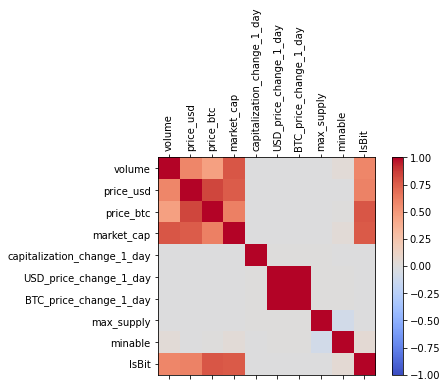

In [5]:
%matplotlib inline
graph_df = df.select_dtypes(exclude="object")
corr = graph_df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(graph_df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(graph_df.columns)
ax.set_yticklabels(graph_df.columns)
plt.show()

In [6]:
corr_data2 = df[df.columns[1:]].corr()['price_usd'][:]
sorted_corr_data2 = corr_data2.sort_values(kind="quicksort")
print(sorted_corr_data2)

max_supply                    -0.006573
minable                       -0.004673
USD_price_change_1_day        -0.000761
BTC_price_change_1_day        -0.000760
capitalization_change_1_day   -0.000183
volume                         0.589624
IsBit                          0.605991
market_cap                     0.759805
price_btc                      0.838757
price_usd                      1.000000
Name: price_usd, dtype: float64


# 3. Feature Selection

Here I can really start getting some useful information out of the data. In my past experience with feature selection, I noted that gradient boosting generally yielded the best results. I believe this to be due to the higher amount of hyper parameters available for tuning. Furthermore, I came across a package none as XGBoost, which is sort of a "pre-optimized" gradient boosting method. While there are still parameters to train, the core algorithm already comes ready to run. Additionally, there are more functions built around it, and one in particular (DMatrix) is very useful for selecting feature importance. It is also specifically built for numerical data, and as the target attribute is numeric, this approach is very appropriate.

The model actually reduced my input features, which were the non-price related ones, down to the top three features. It also presented their relative usefulness as measured by the F1 score. From here on out, I can focus on these three features with confidence that they will be the ones worht spending time on. 

I also graphed out both their correlation to price_usd, as well as the partial dependencies. Because I trust the results of the XGBoost approach, these were purely for visual representations, but I think it is worthwhile to show.

Finally, I'm using a btc_data data frame that selectus just the Bitcoin records. This will help make the models more focused during testing.

In [7]:
btc_data = df[df['ticker']=='BTC']

In [8]:
final_vars = ['volume', 'market_cap', 'capitalization_change_1_day', 'max_supply', 'minable']
train_y = btc_data.price_usd.values
train_X = btc_data[final_vars]
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=100)
remain_num = 99

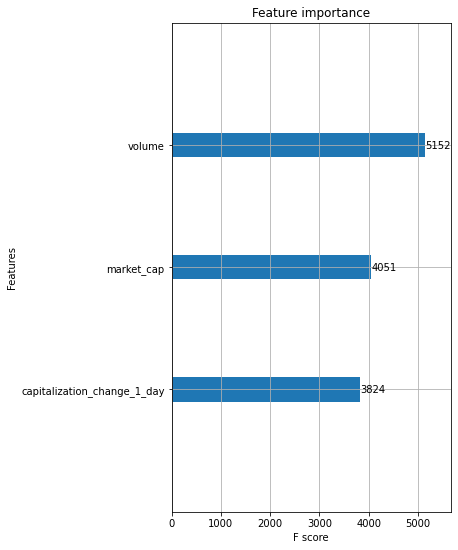

In [9]:
fig, ax = plt.subplots(figsize=(5,9))
xgb.plot_importance(model, max_num_features=remain_num, height=0.2, ax=ax)
plt.show()

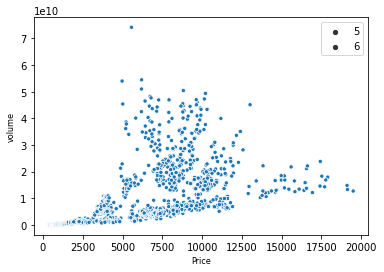

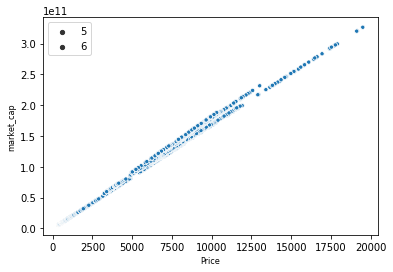

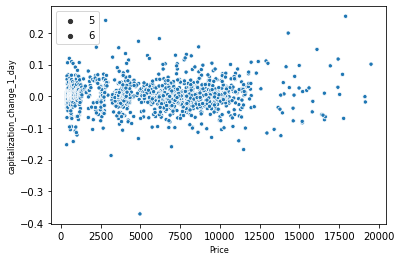

In [10]:
xgb_vars = ['volume', 'market_cap', 'capitalization_change_1_day']
for f in [x for x in xgb_vars]:
    sns.scatterplot(y=btc_data[f].values, x=btc_data.price_usd.values, size=6)
    plt.xlabel('Price', fontsize=8)
    plt.ylabel(f, fontsize=8)
    plt.show()

For additional support, the sugested partial plots of the three most important features. Note that I used a generic gradient boosting model simply to help visualize. However I believe this method was not as helpful as the above scatter plots. 

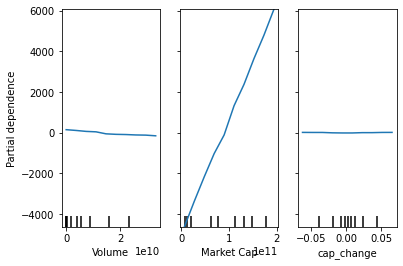

In [11]:
y = btc_data.price_usd
X = btc_data[xgb_vars]
my_model = GradientBoostingRegressor()
my_model.fit(X, y)
my_plots = plot_partial_dependence(my_model,       
                                   features=[0, 1, 2], # column numbers of plots we want to show
                                   X=X,            # raw predictors data.
                                   feature_names=['Volume', 'Market Cap', 'cap_change'], # labels on graphs
                                   grid_resolution=10,
                                   target='price_usd') # number of values to plot on x axis

# 4. Regression Algorithms

Due to the continuous nature of the target variable, price, I will apply several regression algorithms and test their accuracy independently. However, unless one method is markedly less accurate/inappropriate than the others, I will use all of them in the ensemble section later. Regression algorithms are used as the data is continuous, so classification algorithms are no applicable here.

To start, I will setup a a driver function to divide the data into train/test, and make sure that each model is looking at exactly the same thing. From there, I will tune the hyperparameters for each one individually. I do not plan to spend much time exacting the absolute best combination of hyperparameters as I will ultimately be combining them. However, I do want to try and find good examples of each algorithm.

In [46]:
time_data = btc_data['price_usd']
total = df[df.ticker=='BTC'].shape[0]
test = int(round(total * .3))
train = total - test
buff = 80

prev_values = time_data.iloc[:1200]
y_train3 = time_data[buff:train]
y_test3 = time_data[train:]
X_train3 = pd.DataFrame([list(time_data[i:i+buff]) for i in range(train - buff)],
                       columns=range(buff,0,-1),index=y_train3.index)
X_test3 = pd.DataFrame([list(time_data[i:i+buff]) for i in range(train - buff,total - buff)],
                       columns=range(buff,0,-1),index=y_test3.index)
    
def plot_pred(pred,title):
    plt.figure(figsize=(17,5))
    plt.plot(prev_values,label='Train')
    plt.plot(y_test3,label='Actual')
    plt.plot(pred,label='Predicted')
    plt.ylabel("Stock prices")
    plt.title(title,fontsize=20)
    plt.legend()
    plt.show()

def evaluate(model):
    out_mod = model.fit(X_train3, y_train3)
    y_pred_mod = model.predict(X_test3)
    print('Accuracy: ', out_mod.score(X_test3, y_test3))
    print('MSE: ',"%.2f" % mse(y_pred_mod,y_test3))
    print('MAE: ',"%.2f" % mae(y_pred_mod,y_test3))
    # return out_mod
    return y_pred_mod

Accuracy:  0.9677922342356337
MSE:  195745.43


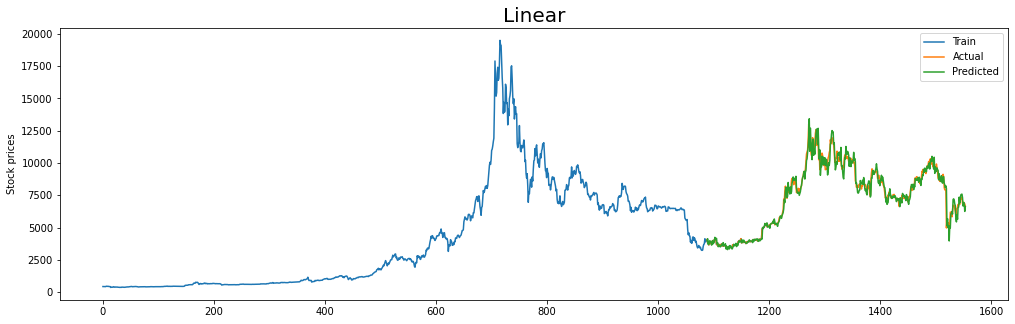

In [13]:
regl = linear_model.LinearRegression()
regl_train = evaluate(regl)
regl_train2 = pd.Series(regl_train[:],index=y_test3.index)
plot_pred(regl_train2,"Linear")

Accuracy:  0.9677923240869051
MSE:  195744.89
MAE:  306.40


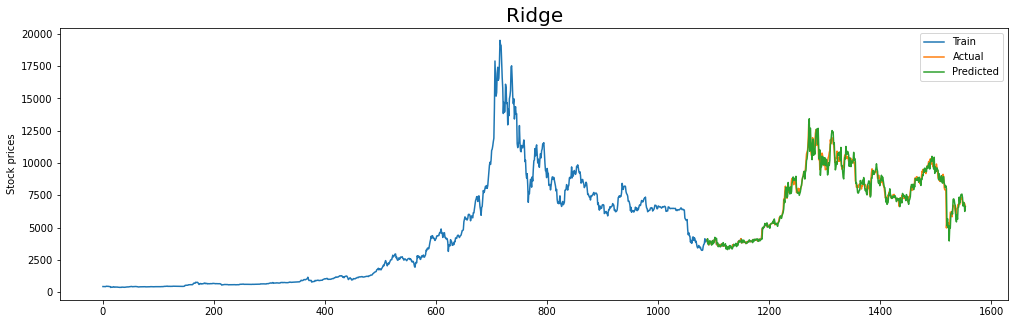

In [47]:
regr = linear_model.Ridge(alpha=200)
regr_train = evaluate(regr)
regr_train2 = pd.Series(regr_train[:],index=y_test3.index)
plot_pred(regr_train2,"Ridge")

Accuracy:  0.9644886506937759
MSE:  215823.24


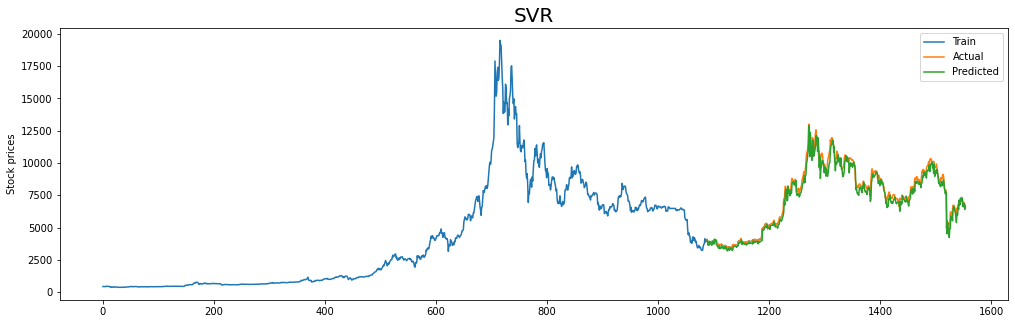

CPU times: user 416 ms, sys: 697 ms, total: 1.11 s
Wall time: 303 ms


In [15]:
%%time
reg_svr = make_pipeline(LinearSVR())
reg_svr_train = evaluate(reg_svr)
reg_svr_train2 = pd.Series(reg_svr_train[:],index=y_test3.index)
plot_pred(reg_svr_train2,"SVR")

# 5. Time Series Analysis

To help in predicting the next day's price, I will be employing a time series strategy. Thus far, I have been very happy with a sequential nerual network, which is implemented through Keras (using the standard Tensor Flow backend). This approach is beneficial because it is set up for a situation where each layer has one input node and one output node, with a linear focus. So this method would not work with a multi-branching approach or residual connections. In the case of pricing data, we specifically have only one input and one output per layer, and we actually want a linear output. 

The other benefit is that it is not (relatively) computationally intesive. Due to the linear nature, it is very quick to generate a multi-layered neural network. On a mid-range CPU, I am able to run 250 iterations in seconds. This generates a comprehensive look at the data in a very short time. 

Before getting to the sequential neural network,I wanted to show a couple of other approaches as a comparison. The cell below has the driver function, which splits the data between a train/test amount (using 70% train/30% test) as well as a graph helper function. I'm showing the basic average only as an example of the driver data, its "result" is completely useless. 

Next I included a basic moving average approach which yielded more benefit than I would have initially thought. First, the results were, at least visually, somewhat close to the actual price. At least the general trend of up or down was followed, and save for some larger price moves the overall direction of the price was maintained. Second, this helped support my train/test decision: if the moving average was on the right track, then I believe to have a great starting point for the neural network.

Finally, the SNN, which of course had the best results. To help measure the relative effectiveness, I used the mean squared error (MSE) which is a common financial metric. While related to risk, it helps measure expected value, and is appropriate for price prediction. Looking at the MSE for the moving average as compared to the SNN, we see that it is almost **five times less accurate**. This is just a relative measure between the two approaches, but shows just how powerful the SNN is.

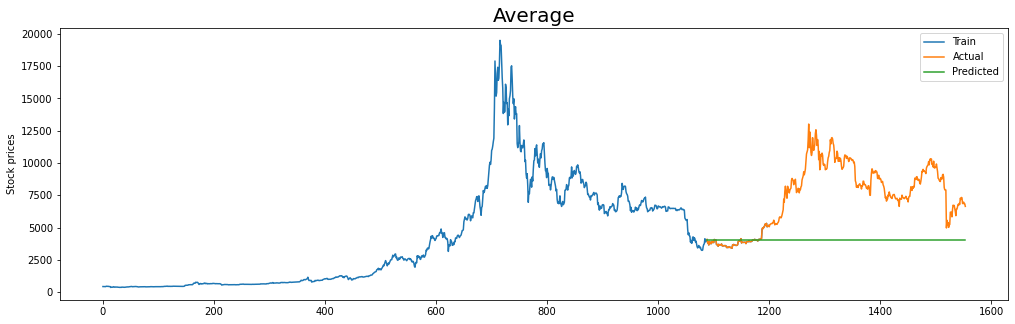

In [16]:
# First, as a baseline, simple average
y_av = pd.Series(np.repeat(prev_values.mean(),test),index=y_test3.index)
plot_pred(y_av,"Average")

2597591.6236692816


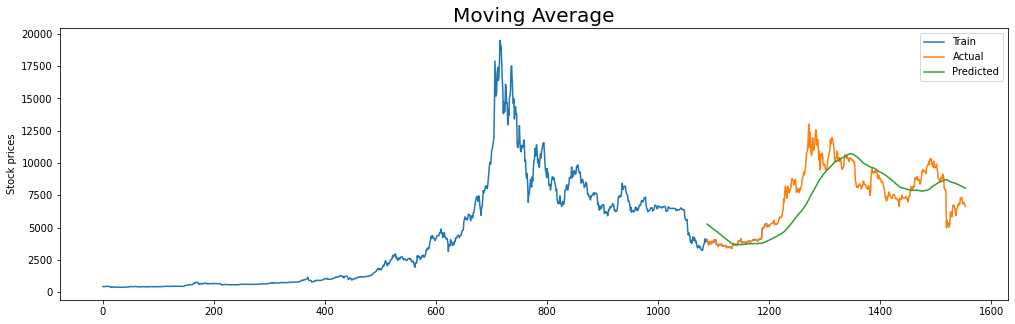

In [17]:
# Next, as a non-linear approach, the moving average
y_ma = X_test3.mean(axis=1)
print(mse(y_ma,y_test3))
plot_pred(y_ma,"Moving Average")

In [18]:
%%time
%%capture
ma_nn = Sequential([Dense(64,input_shape=(buff,),activation='relu'),Dense(32,activation='linear'),Dense(1)])
ma_nn.compile(loss='mse',optimizer='rmsprop',metrics=['mae','mse'])
history = ma_nn.fit(X_train3, y_train3, epochs=250, batch_size=32, validation_split=0.25)
y_nn = ma_nn.predict(X_test3)
y_nn2 = pd.Series(y_nn[:,0],index=y_test3.index)

CPU times: user 4.45 s, sys: 197 ms, total: 4.64 s
Wall time: 3.26 s


675083.94


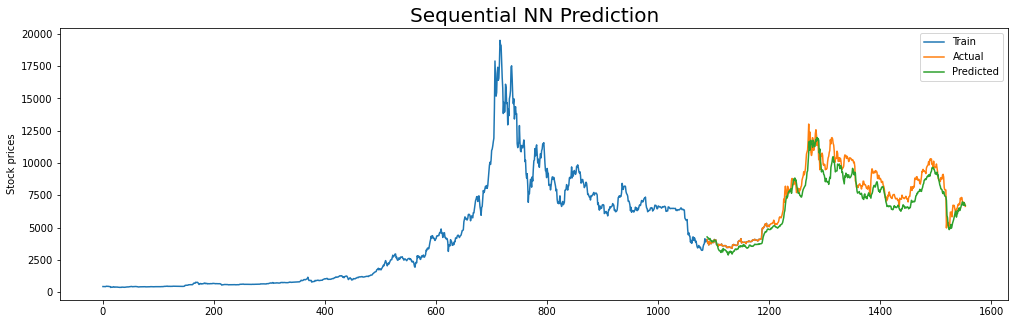

In [19]:
print("%.2f" % mse(y_nn2,y_test3))
plot_pred(y_nn2,"Sequential NN Prediction")

# 6. Ensemble Method
In an effort to reduce the MSE even further, I employed two different ensemble methods. While setting them up was quite satisfying, the results were less so. In short, the performance of the linear SVR algorithm outperformed everything else by so much that giving additional weights to the other "worse" models just increaed the MSE.

I still believe this was a valuable acadmeic endeavor, and also interesting. To start, I first plotted the main four models I will be using on top of each other. Most are so close that the resulting graph is mostly nonesense. After that, I used hard voting to take the mode of every single data point between the four models. This produced less than stellar results. Finally, I used a weighting method where I assigned arbirtary weights to each model. I focused on the best peforming ones, but still gave some weights to the others. My thought was there could perhaps be some outliers/tougher decisions that the lesser models could help with. While this approach performed much better than the hard voting, it still was not as good as the linear SVR.

In [20]:
ens_mods = [regl_train2, regr_train2, reg_svr_train2, y_nn2]

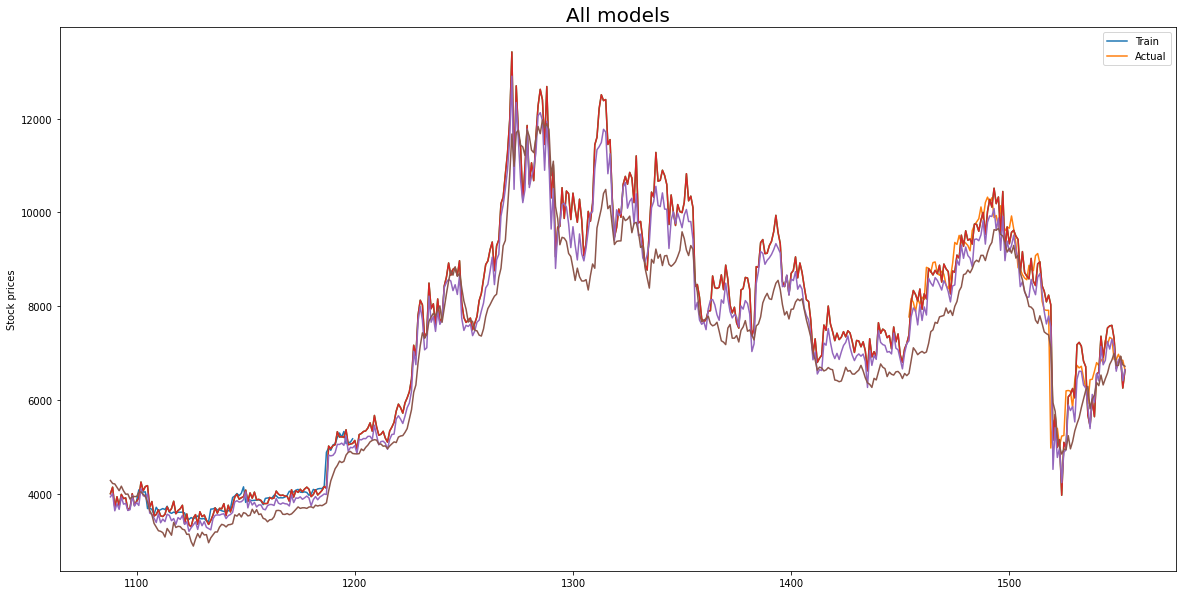

In [21]:
plt.figure(figsize=(20,10))
plt.plot(prev_values[-100:],label='Train')
plt.plot(y_test3[-100:],label='Actual')
for m in ens_mods:
    plt.plot(m)
plt.ylabel("Stock prices")
plt.title('All models',fontsize=20)
plt.legend()
plt.show()

675653.38


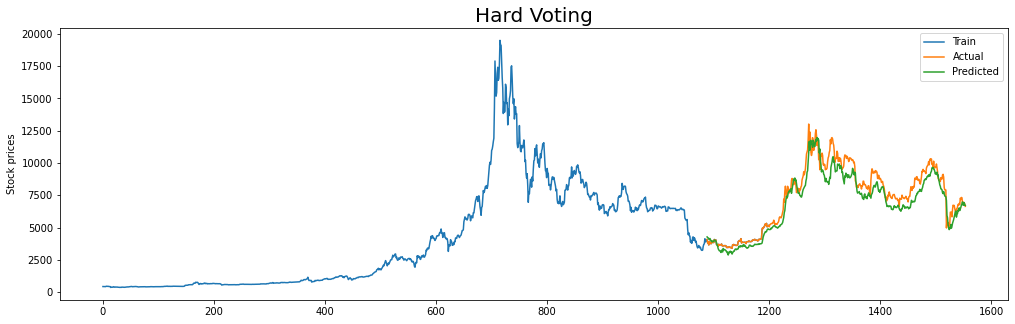

CPU times: user 112 ms, sys: 4.36 ms, total: 117 ms
Wall time: 115 ms


In [33]:
%%time
# hard voting
final_pred = np.array([])
for i in range(0,len(X_test3)):
    final_pred = np.append(final_pred, mode([int(y_nn[i]), regr_train[i], regl_train[i], reg_svr_train[i]]))
final_pred2 = pd.Series(final_pred[:],index=y_test3.index)
print("%.2f" % mse(final_pred2,y_test3))
plot_pred(final_pred2, 'Hard Voting')

191082.55


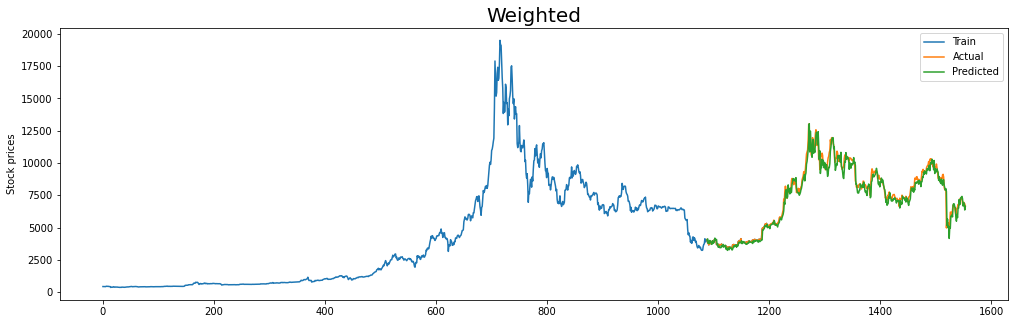

CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 120 ms


In [34]:
%%time
# weighted
final_pred_w = np.array([])
for i in range(0,len(X_test3)):
    final_pred_w = np.append(final_pred_w, (.17*int(y_nn[i]) + .33*regr_train[i] + .33*regl_train[i] + .17*reg_svr_train[i]))
final_pred_w2 = pd.Series(final_pred_w[:],index=y_test3.index)
print("%.2f" % mse(final_pred_w2,y_test3))
plot_pred(final_pred_w2, 'Weighted')

# 7. Different Currencies

To really test the effectiveness of my models, I tested several more of the more popular coins. As a refresher, there are hundreds of crytpocurrencies available in this dataset. Unfortunately many trade under $10 or even $5, which relatively minimal fluctuations. So I focused on the more "robust" ones in the hopes of finding some unique data. Also not every currency had a record for every day listed, so I sorted by the currencies with the most days in the file and ran my linear SVR on those.

I have a couple of helper functions to generate my train/test data, create a trained model, and finally graph the results (following the same conventions as previous sections).

In [24]:
def data_gen(ticker):
    tmp_data = df[df['ticker']==ticker]
    price_data = tmp_data['price_usd']
    total = df[df.ticker==ticker].shape[0]
    test = int(round(total * .6))
    train = total - test
    buff = 80

    prev = price_data.iloc[:1200]
    y_train = price_data[buff:train]
    y_test = price_data[train:]
    x_train = pd.DataFrame([list(price_data[i:i+buff]) for i in range(train - buff)],
                           columns=range(buff,0,-1),index=y_train.index)
    x_test = pd.DataFrame([list(price_data[i:i+buff]) for i in range(train - buff,total - buff)],
                           columns=range(buff,0,-1),index=y_test.index)
    
    return x_train, y_train, x_test, y_test, prev
    

def evaluate_tick(model, xtrain, ytrain, xtest, ytest):
    out_mod = model.fit(xtrain, ytrain) 
    y_pred_mod2 = model.predict(xtest) 
    print('Accuracy: ', out_mod.score(xtest, ytest))
    print('MSE: ',"%.2f" % mse(y_pred_mod2,ytest))
    # return out_mod
    return y_pred_mod2

def plot_pred_tick(pred,title, test, pre):
    plt.figure(figsize=(17,5))
    plt.plot(pre,label='Train')
    plt.plot(test,label='Actual') #y_test3
    plt.plot(pred,label='Predicted')
    plt.ylabel("Stock prices")
    plt.title(title,fontsize=20)
    plt.legend()
    plt.show()

In [25]:
df_tick = df['ticker'].value_counts()>1550
df_tick.head(10)

LBTC    True
FTC     True
FLO     True
XRP     True
LTC     True
DASH    True
BTC     True
XVG     True
IOC     True
VTC     True
Name: ticker, dtype: bool

Accuracy:  0.935028512584221
MSE:  376.03


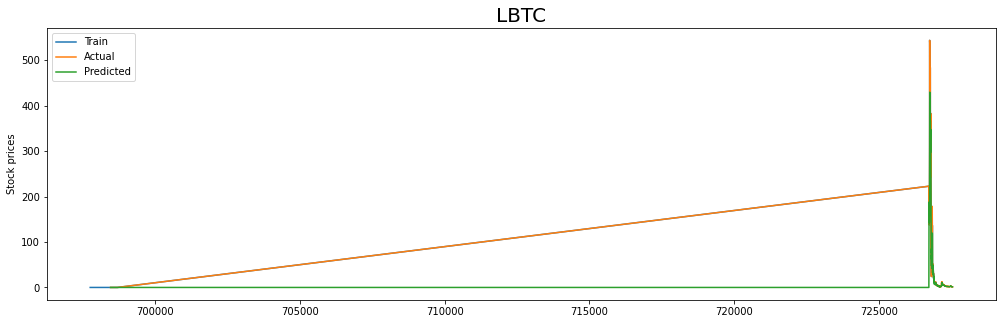

In [26]:
coinl = 'LBTC'
trainxl, trainyl, testxl, testyl, prev_inputl = data_gen(coinl)
lbtc_mod = evaluate_tick(reg_svr, trainxl, trainyl, testxl, testyl)
lbtc_shift = pd.Series(lbtc_mod[:],index=testyl.index)
plot_pred_tick(lbtc_shift, coinl, testyl, prev_inputl)

Accuracy:  0.9796069942272243
MSE:  0.00


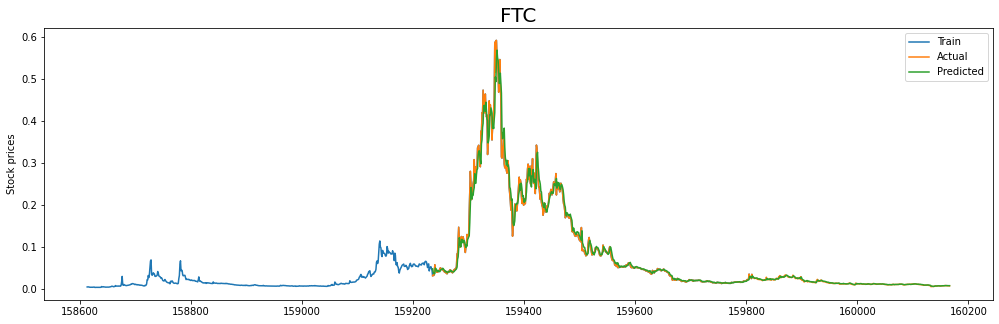

In [29]:
coinf = 'FTC'
trainxf, trainyf, testxf, testyf, prev_inputf = data_gen(coinf)
ftc_mod = evaluate_tick(reg_svr, trainxf, trainyf, testxf, testyf)
ftc_shift = pd.Series(ftc_mod[:],index=testyf.index)
plot_pred_tick(ftc_shift, coinf, testyf, prev_inputf)

Accuracy:  0.9593687742782361
MSE:  0.01


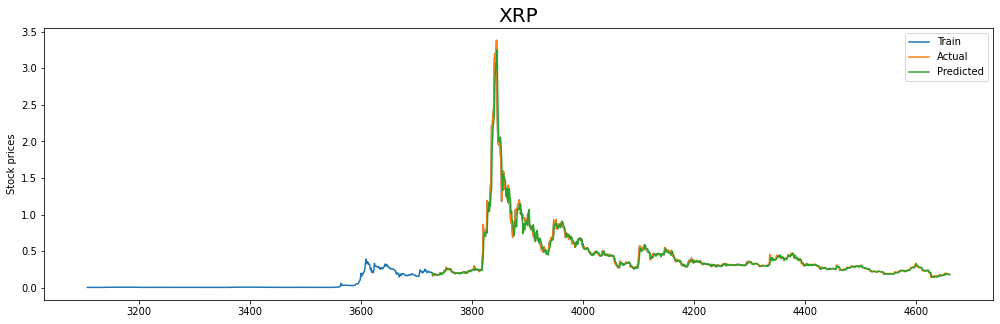

In [30]:
coinx = 'XRP'
trainxx, trainyx, testxx, testyx, prev_inputx = data_gen(coinx)
xrp_mod = evaluate_tick(reg_svr, trainxx, trainyx, testxx, testyx)
xrp_shift = pd.Series(xrp_mod[:],index=testyx.index)
plot_pred_tick(xrp_shift, coinx, testyx, prev_inputx)

Accuracy:  0.9817206573287891
MSE:  1132.63


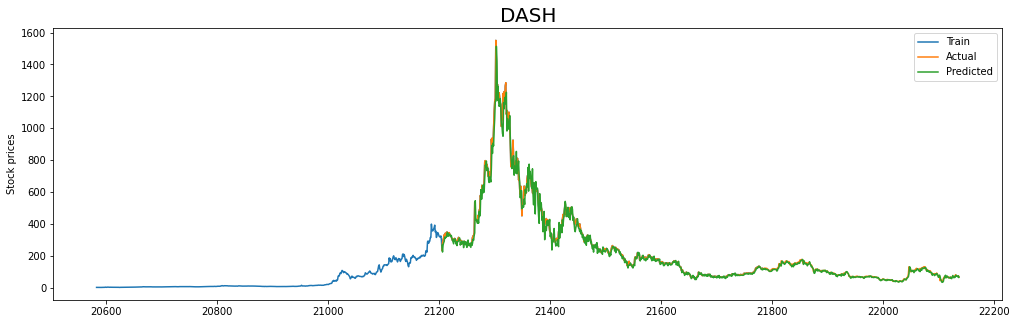

In [31]:
coind = 'DASH'
trainxd, trainyd, testxd, testyd, prev_inputd = data_gen(coind)
dash_mod = evaluate_tick(reg_svr, trainxd, trainyd, testxd, testyd)
dash_shift = pd.Series(dash_mod[:],index=testyd.index)
plot_pred_tick(dash_shift, coind, testyd, prev_inputd)

# 8. Summary

After going through this dataset extensively and examing it from multiple perspectives, a few things have stuck out. First, I was very surprised at how well the regression algorithms perfomred. I would have assumed that a nerual net would far outperform them, but that was simply not the case. The linear SVR method is certainly an advanced algorithm, but it is a relatively simple approach (as opposed to a neural network).

Another thing that surprised me was the strong accuracy of these models. Just visually, looking at the predicted vs. actual lines, these models were really close in some pretty volatile time periods. To predict the big jumps and drops is very impressive for again, a relatively simple model. I suppose it's only simple in the lack of hyperparameter tuning, wher simply having enough time series data to train on could generate strong predictive metrics.

The last thing that I didn't expect to see was how well the models applied to other currencies. At the start, I just assumed that Bitcoin would be the easiest to predict, since it's the most widely known and traded **by far**. However, the spotlight that Bitcoin has actually makes it more volatile than other cryptocurrencies, and on a more docile dataset the models perform even better.

It should be noted that the MSE number is, on the one hand, a good measure of accuracy as it can be standardized across the different models. On the other hand, when looking at different currencies, it falls a little short. When the relative price of a coin is an order of magnitude less, the "error" will be also. So it is somewhat inappropriate to compare the MSE of Bitcoin and say XRP with the same algorithm. One must compare the MSE between currencies and different algorithms. This is a small point, and doesn't change the analysis.

Before concluding, I'd like to include two more subsections, one on a summary of the models tested, and one simply comparing the best peforming model I had to the previous one on Kaggle.

## 8.1 Model Summary

In [42]:
table_data=[
    ['Linear Regression', 195745.43, '<1'],
    ['Ridge Regression', 195744.89, '<1'],
    ['Linear SVR', 215823.24, '<1'],
    ['Moving Average', 2597591.62, '<1'],
    ['Sequential Nerual Network', 675083.94, '4.64'],
    ['Ensemble - Hard Voting', 675653.38, '<1*'],
    ['Ensemble - Weighted', 191082.55, '<1*'],
]
df_table = pd.DataFrame(table_data)
# sort table in descending order by accuracy
df_table = df_table.sort_values(by=[1], kind="quicksort", ascending=True)
#df_table[2] = pd.Series(["{0:.1f}%".format(val * 100) for val in df_table[2]], index = df_table.index)
fig = go.Figure(data=[go.Table(header=dict(values=['Method','MSE', 'Time (seconds)']),
                 cells=dict(values=[df_table[0], df_table[1], df_table[2]]))
                     ])
fig.show()

## 8.2 Kaggle Comparision

When I began looking at this dataset, I couldn't even really follow the other kernel on Kaggle. After several weeks of understanding, I now have a more clear picture. The other kernel employed a very different approach, a Long short-term memory (LSTM) model, which is something I didn't even consider. Also, while the other kernel used MAE, so the comparison to mine don't make any sense (mine are several orders of magnitude different). In order to compare, I ran the MAE on my best peforming algorithm, and was very close to the Kaggle results: I had an MAE of 306 vs. the Kaggle of 273. Given that time periods were shifted, I am extremely pleased.

There is one very interesting graph at the end, where the author presents a comparison of the best model to the actual price. The peformance, at least visually, appears to be very good, and also on par to what I came up with as well. I believe the similarity in these two graphs speaks to the success of my approach.

First, the other Kaggle kernel result:

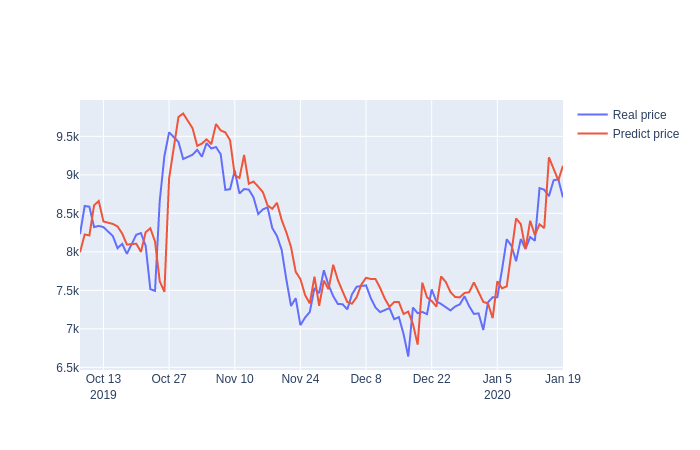

Second, my best result. Note that this Kaggle dataset gets updated regularly, so I had more current data than the other Kaggle kernel, which was run in January. Also the x axis in my graph is in days:

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=btc_data.iloc[btc_data.shape[0]-100:]['price_usd'], name='Real price'))
fig.add_trace(go.Scatter(y=reg_svr_train[-100:], name='Predict price'))
fig.show()